In [26]:
# Import libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense
import tensorflow_datasets as tfds

In [27]:
# Extract data
data = pd.read_csv('../../ETL/Load/stockData.csv', header=(0), sep=';')

In [28]:
# Replace inf values by very large number
data.replace(np.inf, 1e20, inplace=True)
# Replace 0 class to -1 (for the tanh activation function)
data['CLASS'] = data['CLASS'].replace(0, -1)

In [29]:
data

,TICKER,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,CLASS
0,ABEV3,2014-07-01,21.706832,2.906275,0.258062,0.634963,0.029252,5.601715,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
1,ABEV3,2014-08-01,22.676506,2.906275,0.258062,0.634963,0.028001,5.851952,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
2,ABEV3,2014-09-01,22.219375,2.906275,0.258062,0.634963,0.028577,5.733983,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
3,ABEV3,2014-10-01,22.718062,2.906275,0.258062,0.634963,0.027950,5.862676,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
4,ABEV3,2014-11-01,23.216752,2.906275,0.258062,0.634963,0.027349,5.991369,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358,YDUQ3,2023-08-01,-102.017902,10.561267,-0.018731,-0.677386,0.006640,1.910868,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-1
11359,YDUQ3,2023-09-01,-99.513781,10.561267,-0.018731,-0.677386,0.006807,1.863964,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-1
11360,YDUQ3,2023-10-01,-88.796136,10.561267,-0.018731,-0.677386,0.007629,1.663214,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-1
11361,YDUQ3,2023-11-01,-100.615591,10.561267,-0.018731,-0.677386,0.006732,1.884601,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-1


In [30]:
# Separate train and test data
# Train: first 8 years
# Test: last 2 years

data['DATE'] = pd.to_datetime(data['DATE'])
data_train = data[data['DATE'].dt.year <= 2021]
data_test = data[data['DATE'].dt.year > 2021]

In [31]:
data_train = data[data['DATE'].dt.year <= 2021]
data_test = data[data['DATE'].dt.year > 2021]

In [32]:
# Function to remove outliers using std
def remove_outliers_std(data_train, data_test, column, factor = 3):
    data_std = data_train[column].std()
    data_mean = data_train[column].mean()
    lower_bound = data_mean - factor * data_std
    upper_bound = data_mean + factor * data_std
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]
    data_test = data_test[(data_test[column] >= lower_bound) & (data_test[column] <= upper_bound)]
    return data_train, data_test

# Function to remove outliers using IQR
def remove_outliers_iqr(data_train, data_test, column, factor = 1.5):
    Q1 = data_train[column].quantile(0.25)
    Q3 = data_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]
    data_test = data_test[(data_test[column] >= lower_bound) & (data_test[column] <= upper_bound)]
    return data_train, data_test

In [33]:
# List of features and the class column
features = data.columns.tolist()[2:-1]
binary_class = data.columns.tolist()[-1]

# Replace inf values by very large number
data.replace(np.inf, 1e20, inplace=True)

# Clean outliers from data
method = 'iqr' # std or iqr
factor = 6

if method == 'std':
    for feature in features:
        data_train, data_test = remove_outliers_std(data_train, data_test, feature, factor)
elif method == 'iqr':
    for feature in features:
        data_train, data_test = remove_outliers_iqr(data_train, data_test, feature, factor)

In [34]:
# Describe train data without outliers
data_train.describe()

,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,CLASS
count,6382,6382.000000,6382.000000,6382.000000,6382.000000,6382.000000,6382.000000,6.382000e+03,6.382000e+03,6.382000e+03,6382.000000,6382.000000,6382.000000
mean,2017-11-25 08:02:10.868066560,17.464242,13.016723,0.114756,0.381386,0.038972,2.809489,9.483619e+09,8.526669e+09,1.228215e+09,1.939992,1.186454,-0.787214
min,2013-01-01 00:00:00,-129.614491,-19.123328,-0.734395,-3.202127,-0.000000,-12.734168,1.036100e+07,0.000000e+00,1.176395e+07,0.106487,-9.420000,-1.000000
25%,2015-11-01 00:00:00,4.730878,6.333591,0.050398,0.075477,0.005890,0.799559,1.663480e+09,1.228257e+09,2.415238e+08,1.199359,0.349498,-1.000000
50%,2018-02-01 00:00:00,12.729293,10.017375,0.118763,0.311868,0.022617,1.707756,4.432090e+09,3.507187e+09,6.438048e+08,1.669399,1.036583,-1.000000
75%,2020-01-01 00:00:00,25.358278,17.098325,0.190011,0.594902,0.052243,3.457008,1.096507e+10,1.118890e+10,1.453851e+09,2.392725,1.962780,-1.000000
max,2021-12-01 00:00:00,157.956622,68.721762,1.077140,3.721054,0.360459,19.468688,1.008661e+11,6.590670e+10,1.016882e+10,8.138526,11.422080,1.000000
std,NaN,29.879530,11.403161,0.183662,0.548711,0.049831,3.297350,1.371170e+10,1.231472e+10,1.707286e+09,1.145933,2.147553,0.616728


In [35]:
# Describe test data without outliers
data_test.describe()

,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,CLASS
count,1740,1740.000000,1740.000000,1740.000000,1740.000000,1740.000000,1740.000000,1.740000e+03,1.740000e+03,1.740000e+03,1740.000000,1740.000000,1740.000000
mean,2022-12-26 08:28:57.931034624,14.076735,11.536844,0.164054,0.365136,0.051429,2.355197,1.113130e+10,1.074184e+10,1.587576e+09,1.964724,1.564557,-0.909195
min,2022-01-01 00:00:00,-129.330435,-44.434689,-0.544953,-2.428702,-0.000000,-2.014198,6.943000e+06,0.000000e+00,1.176409e+07,0.070706,-4.911970,-1.000000
25%,2022-07-01 00:00:00,4.392125,4.448813,0.074769,0.052706,0.006540,0.787417,2.593505e+09,1.976992e+09,4.186071e+08,1.309137,0.524220,-1.000000
50%,2023-01-01 00:00:00,9.099089,9.062375,0.141892,0.289964,0.023661,1.590059,7.909456e+09,6.276182e+09,9.552082e+08,1.663042,1.146850,-1.000000
75%,2023-07-01 00:00:00,20.949939,15.585425,0.215820,0.566766,0.066325,2.986911,1.545620e+10,1.419864e+10,1.948209e+09,2.310015,2.163800,-1.000000
max,2023-12-01 00:00:00,158.942935,61.243413,0.915534,1.886858,0.362852,13.895744,6.053730e+10,6.590670e+10,1.004250e+10,10.212709,9.040000,1.000000
std,NaN,25.003587,11.135142,0.180802,0.502666,0.070055,2.408080,1.091857e+10,1.234197e+10,1.821735e+09,1.231124,1.900400,0.416489


In [36]:
# Change data to numpy
data_train = data_train.to_numpy()
data_test = data_test.to_numpy()

# Get number of rows and columns
ncol = data.shape[1]

# Get arrays for features and class
y_train = data_train[:,-1]
X_train = data_train[:,2:ncol-1]
y_test = data_test[:,-1]
X_test = data_test[:,2:ncol-1]

In [37]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [38]:
# Convert y to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [39]:
# Upsample 1 Class
# Convert X_train and y_train to DataFrame and Series, respectively
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# Split the dataset by class
X_train_majority = X_train[y_train == -1]
X_train_minority = X_train[y_train == 1]

y_train_majority = y_train[y_train == -1]
y_train_minority = y_train[y_train == 1]

# Resample minority class to match the majority class size
X_train_minority_upsampled = resample(X_train_minority, 
                                      replace=True,     
                                      n_samples=len(X_train_majority),  
                                      random_state=42)

y_train_minority_upsampled = resample(y_train_minority, 
                                      replace=True,     
                                      n_samples=len(y_train_majority),  
                                      random_state=42)

# Combine majority class and upsampled minority class
X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])

# Shuffle the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [40]:
## Define adaptative learning rate
#def scheduler(epoch, lr):
#  if epoch < 2:
#    return lr
#  else:
#    return np.round(lr * tf.math.exp(-0.1), 6)

#callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [41]:
# Implement MLP
epochs = 500

# Number of input features
input_neurons = 11

# Create the MLP model
MLP = Sequential()

# Define the input layer
MLP.add(Input(shape=(input_neurons,)))

# Hidden layer with 22 neurons (2x input neurons) and tangent sigmoid activation
MLP.add(Dense(22, activation='tanh'))

# Output layer with tangent sigmoid activation
MLP.add(Dense(1, activation='tanh'))

# RMSprop with learning rate, decay, and momentum
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Compile the model
MLP.compile(optimizer=optimizer, loss='mean_squared_error')

# Summary of the model
MLP.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 22)                  │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287 (1.12 KB)

 Trainable params: 287 (1.12 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
histMLP = MLP.fit(
    X_train_balanced,
    y_train_balanced,
    epochs=epochs,
    verbose=2
)

Epoch 1/500
357/357 - 0s - 1ms/step - loss: 0.9066
Epoch 2/500
357/357 - 0s - 543us/step - loss: 0.8201
Epoch 3/500
357/357 - 0s - 535us/step - loss: 0.7397
Epoch 4/500
357/357 - 0s - 529us/step - loss: 0.6798
Epoch 5/500
357/357 - 0s - 522us/step - loss: 0.6424
Epoch 6/500
357/357 - 0s - 513us/step - loss: 0.6174
Epoch 7/500
357/357 - 0s - 529us/step - loss: 0.5898
Epoch 8/500
357/357 - 0s - 510us/step - loss: 0.5814
Epoch 9/500
357/357 - 0s - 532us/step - loss: 0.5445
Epoch 10/500
357/357 - 0s - 541us/step - loss: 0.5278
Epoch 11/500
357/357 - 0s - 522us/step - loss: 0.5109
Epoch 12/500
357/357 - 0s - 542us/step - loss: 0.4895
Epoch 13/500
357/357 - 0s - 529us/step - loss: 0.4820
Epoch 14/500
357/357 - 0s - 524us/step - loss: 0.4692
Epoch 15/500
357/357 - 0s - 521us/step - loss: 0.4603
Epoch 16/500
357/357 - 0s - 510us/step - loss: 0.4492
Epoch 17/500
357/357 - 0s - 512us/step - loss: 0.4390
Epoch 18/500
357/357 - 0s - 537us/step - loss: 0.4318
Epoch 19/500
357/357 - 0s - 544us/step 

Text(0.5, 1.0, 'Loss per epoch')

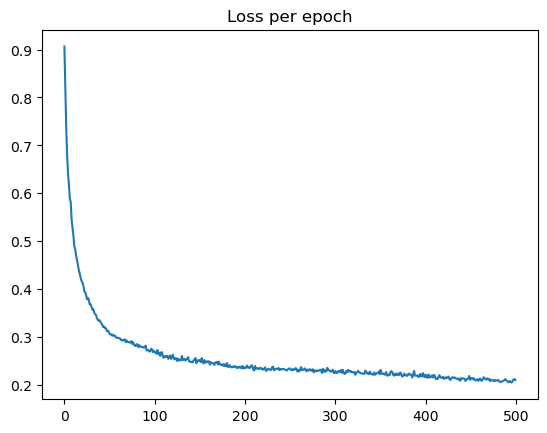

In [43]:
plt.plot(histMLP.history['loss'])
plt.title("Loss per epoch")

In [44]:
# Scale the test data
X_test = scaler.transform(X_test)

In [45]:
# Run model prediction
y_pred = MLP.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


In [46]:
# Get cutoff point
# Generate cutoff points
cutoff_points = np.linspace(-1, 1, 100)

# Initialize lists to store rates
true_positive_rates = []
true_negative_rates = []

# Calculate rates for each cutoff
for cutoff in cutoff_points:
    # Classify predictions based on the cutoff
    y_pred_classes = np.where(y_pred.flatten() >= cutoff, 1, -1)
    
    # Compute true positives and true negatives
    true_positives = np.sum((y_pred_classes == 1) & (y_test == 1))
    true_negatives = np.sum((y_pred_classes == -1) & (y_test == -1))
    
    # Total positives and negatives in the true labels
    total_positives = np.sum(y_test == 1)
    total_negatives = np.sum(y_test == -1)
    
    # True positive rate (TPR) and true negative rate (TNR)
    tpr = true_positives / total_positives if total_positives > 0 else 0
    tnr = true_negatives / total_negatives if total_negatives > 0 else 0
    
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

# Find the cutoff where the two curves cross
# This happens when |TPR - TNR| is minimized
tpr_array = np.array(true_positive_rates)
tnr_array = np.array(true_negative_rates)
cutoff_cross = cutoff_points[np.argmin(np.abs(tpr_array - tnr_array))]

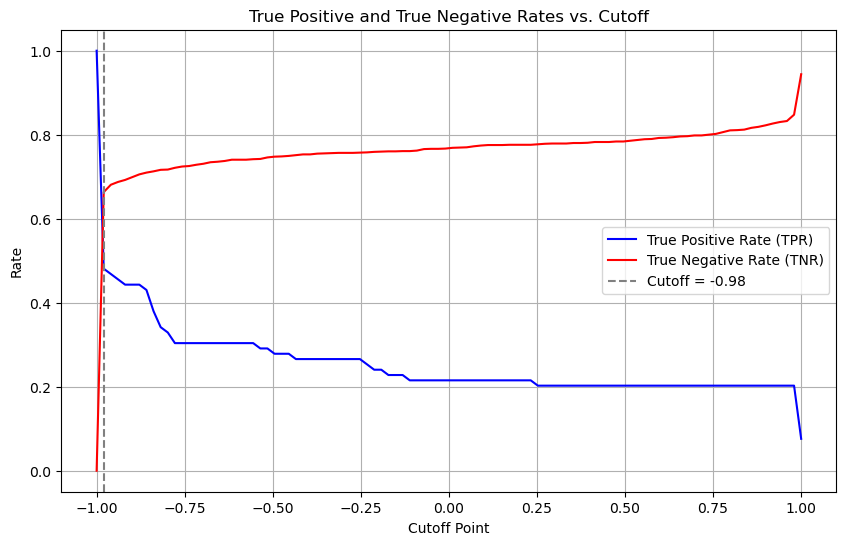

In [47]:
# Plot the TPR and TNR
plt.figure(figsize=(10, 6))
plt.plot(cutoff_points, true_positive_rates, label='True Positive Rate (TPR)', color='blue')
plt.plot(cutoff_points, true_negative_rates, label='True Negative Rate (TNR)', color='red')
plt.axvline(cutoff_cross, color='gray', linestyle='--', label=f'Cutoff = {round(cutoff_cross,3)}')
plt.xlabel('Cutoff Point')
plt.ylabel('Rate')
plt.title('True Positive and True Negative Rates vs. Cutoff')
plt.legend()
plt.grid()
plt.show()

In [48]:
# Treat predicted array
y_pred[y_pred>=cutoff_cross] = 1
y_pred[y_pred<cutoff_cross] = 0
y_pred = np.sign(y_pred.flatten())
y_pred.astype(int)

# Treat test array
y_test[y_test==-1] = 0

In [49]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

Accuracy: 0.6551724137931034
Precision: 0.06365159128978225
Recall (Sensitivity): 0.4810126582278481
F1-Score: 0.11242603550295859


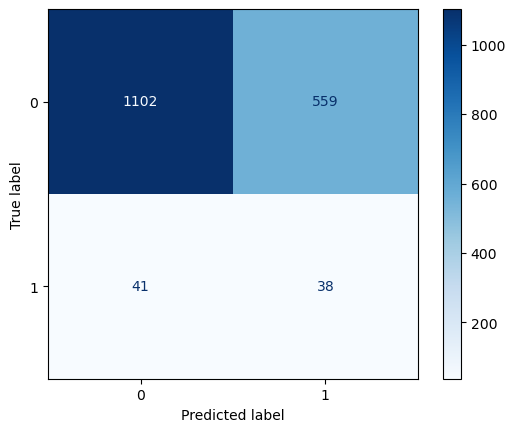

In [50]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()